In [1]:
import os
import datetime
import time
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,MaxPooling2D,Dense,concatenate
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,Conv2DTranspose
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.metrics import Recall, Precision,MeanIoU,AUC
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model



Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
IMAGE_SIZE = 256
EPOCHS = 50
BATCH = 4
LR = 1e-7

PATH = '../../dataset/LSP/train/'

In [4]:
def load_data(path='../dataset/LSP/train/', split=0.1,mode=''):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    
    if mode == 'training':
        total_size = len(images)
        valid_size = int(split * total_size)
        train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
        train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

        return (train_x, train_y), (valid_x, valid_y)
    
    if mode == 'testing':
        return (images,masks)

In [5]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [6]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
#     dataset = dataset.repeat()
    return dataset

In [7]:
(train_x, train_y), (valid_x, valid_y) = load_data(PATH,mode='training')

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))

Training data:  1359
Validation data:  150


In [8]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

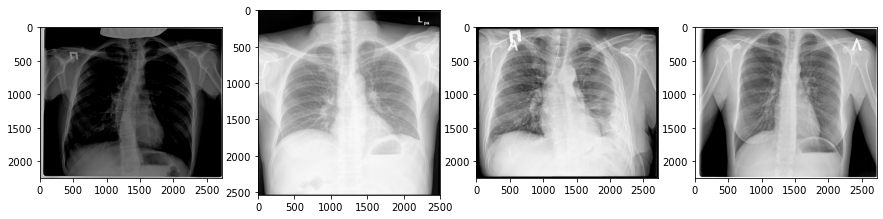

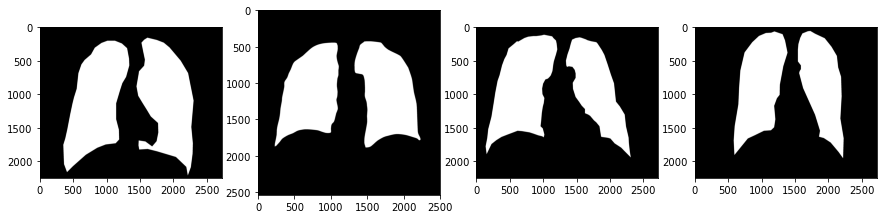

In [9]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(valid_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(valid_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(valid_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(valid_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(valid_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(valid_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(valid_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(valid_y[3]))
imgplot.set_clim(0.0, 1.4)

In [10]:
def build_model(inputs):
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    mobilenetv2.trainable = False
    x = mobilenetv2.get_layer('out_relu').output
    x = Conv2D(128,3,name='final_conv',padding='same',activation='relu')(x)
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(2,activation='sigmoid')(x)
    return tf.keras.Model(inputs,output)



In [11]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = build_model(inputs)
    encoder.load_weights('../../output/checkpoints/mobilenetv2/512_128weights.16-0.31.hdf5')
    skip_connection_names = ["input_image","block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    f = [ 16, 32, 48, 64,64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    
    return model

In [10]:
def build_model(input_shape=(256,256,1), start_neurons=16):
    
    input_layer = Input(shape=input_shape)
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return tf.keras.models.Model(input_layer, output_layer)

In [25]:
model = build_model(input_shape=(256,256,3), start_neurons=16)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [26]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [27]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [28]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, MeanIoU(num_classes=2), AUC(curve='PR'), Recall(), Precision()]
# model.load_weights('../../output/checkpoints/mobilenetv2/unet_weights.21.0.04.hdf5')
model.compile(loss = dice_loss, optimizer=opt, metrics=metrics)

In [29]:
log_dir = "logs/unet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        '../../output/checkpoints/mobilenetv2/unet_weights.{epoch:02d}.{val_loss:.2f}.hdf5',
        monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

2022-07-13 10:06:43.286505: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-13 10:06:43.286541: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-07-13 10:06:43.286869: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosit

2022-07-13 10:06:44.934704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  1/340 [..............................] - ETA: 20:09 - loss: 0.6117 - dice_coef: 0.3883 - mean_io_u_3: 0.3428 - auc_3: 0.2805 - recall_3: 0.7576 - precision_3: 0.3147

2022-07-13 10:06:47.557849: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-07-13 10:06:47.557862: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/340 [..............................] - ETA: 5:52 - loss: 0.6091 - dice_coef: 0.3909 - mean_io_u_3: 0.3411 - auc_3: 0.2891 - recall_3: 0.7570 - precision_3: 0.3180 

2022-07-13 10:06:48.552682: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-13 10:06:48.558374: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-07-13 10:06:48.563430: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/unet/20220713-100643/train/plugins/profile/2022_07_13_10_06_48
2022-07-13 10:06:48.565427: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/unet/20220713-100643/train/plugins/profile/2022_07_13_10_06_48/users-MacBook-Pro.local.trace.json.gz
2022-07-13 10:06:48.568953: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/unet/20220713-100643/train/plugins/profile/2022_07_13_10_06_48
2022-07-13 10:06:48.569156: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/unet/20220713-100643/train/plugins/

158/340 [============>.................] - ETA: 2:43 - loss: 0.6161 - dice_coef: 0.3839 - mean_io_u_3: 0.3445 - auc_3: 0.2792 - recall_3: 0.7583 - precision_3: 0.3107

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x35414cfa0>
    label = <none> 
    device = <AGXG13GDevice: 0x169856600>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x125008200>
        label = <none> 
        device = <AGXG13GDevice: 0x169856600>
            name = Apple M1 
    retainedReferences = 1


340/340 [==============================] - ETA: 0s - loss: 0.6165 - dice_coef: 0.3834 - mean_io_u_3: 0.3449 - auc_3: 0.2783 - recall_3: 0.7605 - precision_3: 0.3099WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x294365160> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-07-13 10:11:55.858491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


340/340 [==============================] - 342s 998ms/step - loss: 0.6165 - dice_coef: 0.3834 - mean_io_u_3: 0.3449 - auc_3: 0.2783 - recall_3: 0.7605 - precision_3: 0.3099 - val_loss: 0.6241 - val_dice_coef: 0.3757 - val_mean_io_u_3: 0.3489 - val_auc_3: 0.2710 - val_recall_3: 0.7383 - val_precision_3: 0.2941

Epoch 00001: val_loss improved from inf to 0.62407, saving model to ../../output/checkpoints/mobilenetv2/unet_weights.01.0.62.hdf5
Epoch 2/50
 39/340 [==>...........................] - ETA: 4:22 - loss: 0.6125 - dice_coef: 0.3875 - mean_io_u_3: 0.3422 - auc_3: 0.2839 - recall_3: 0.7655 - precision_3: 0.3151

In [ ]:
test_x, test_y= load_data(path='../../dataset/LSP/test/',mode='testing')
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

print("test data: ", len(test_x))
test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

In [ ]:
model.load_weights('../../output/checkpoints/mobilenetv2/unet_weights.07.0.04.hdf5')
model.evaluate(test_dataset)

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x



In [ ]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask



In [ ]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    